In [2]:
import os
import json
import gzip
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
from collections import defaultdict
from urllib.request import urlopen
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# default plot configurations 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()


# Load data

## Load meta data

In [3]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
        if i % 500000 == 0: print(i)
    return pd.DataFrame.from_dict(df, orient='index')

print("Start loading meta data")
meta_data = getDF('meta_Toys_and_Games.json.gz')
print("Finish loading meta data")
# total length of list, this number equals total number of products
print(len(meta_data))

Start loading meta data
500000
Finish loading meta data
633883


## Load review data

In [4]:
print("Start loading review data")
review_data = getDF('Toys_and_Games.json.gz')
print("Finish loading review data")

# total length of list, this number equals total number of products
print(len(review_data))

Start loading review data
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000
7000000
7500000
8000000
Finish loading review data
8201231


## Meta data preprocessing

In [5]:
meta_data.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Toys & Games, Puzzles, Jigsaw Puzzles]",,"[Three Dr. Suess' Puzzles: Green Eggs and Ham,...",,Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle,[],,Dr. Seuss,"[Three giant floor puzzles, Includes: Dr. Sues...","[>#2,230,717 in Toys & Games (See Top 100 in T...",[],Toys & Games,,,,0000191639,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,[],,[<b>Prepare to be Afraid!</b><br /><br />The B...,,Pathfinder: Book of Beasts - Legendary Foes,[],,Pathfinder Roleplaying Jon Brazer Productions,[],"[>#2,294,535 in Toys & Games (See Top 100 in T...",[],Toys & Games,,,.a-box-inner{background-color:#fff}#alohaBuyBo...,0004950763,[],[],NaN
2,[],,[],,Nursery Rhymes Felt Book,[],,Betty Lukens,[],"[>#2,871,983 in Toys & Games (See Top 100 in T...",[],Toys & Games,,,.a-box-inner{background-color:#fff}#alohaBuyBo...,0005069491,[],[],NaN
3,"[Toys & Games, Games, Card Games]",,[Blitz Vintage Card Game],,Dutch Blitz Card Game,[B00WIIPQEC],,Dutch Blitz Games Co,[],"[>#376,337 in Toys & Games (See Top 100 in Toy...","[B000BBU0KS, B00NQQTZ5G, B00WIIPQEC, B001VIWAO...",Toys & Games,"class=""a-bordered a-horizontal-stripes a-spa...",,$24.95,0004983289,[],[],NaN
4,[],,"[Marvel SuperHeroes themed ""magic ink"" colorin...",,Magic Pen Painting (Marvel Super Heroes),"[B009SB7TI8, B009SB8Z1I]",,Lee Publications,[],"[>#934,954 in Toys & Games (See Top 100 in Toy...",[],Toys & Games,,,$4.92,0006466222,[],[],NaN


In [6]:
meta_data['price'].str.match(r'\$[0-9]*.[0-9]*')

0         False
1         False
2         False
3          True
4          True
          ...  
633878     True
633879    False
633880     True
633881     True
633882    False
Name: price, Length: 633883, dtype: bool

### Remove useless cell

In [7]:
meta_data_1 = meta_data[meta_data['price'].str.match(r'\$[0-9]*.[0-9]*')]
meta_data_1['intPrice'] = meta_data_1['price'].str.extract(r'\$(.*)')
meta_data_1['intPrice'] = pd.to_numeric(meta_data_1['intPrice'],errors='coerce')
meta_data_1.head()

<ipython-input-7-4ab99c3ee620>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data_1['intPrice'] = meta_data_1['price'].str.extract(r'\$(.*)')
<ipython-input-7-4ab99c3ee620>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data_1['intPrice'] = pd.to_numeric(meta_data_1['intPrice'],errors='coerce')


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details,intPrice
3,"[Toys & Games, Games, Card Games]",,[Blitz Vintage Card Game],,Dutch Blitz Card Game,[B00WIIPQEC],,Dutch Blitz Games Co,[],"[>#376,337 in Toys & Games (See Top 100 in Toy...","[B000BBU0KS, B00NQQTZ5G, B00WIIPQEC, B001VIWAO...",Toys & Games,"class=""a-bordered a-horizontal-stripes a-spa...",,$24.95,0004983289,[],[],NaN,24.95
4,[],,"[Marvel SuperHeroes themed ""magic ink"" colorin...",,Magic Pen Painting (Marvel Super Heroes),"[B009SB7TI8, B009SB8Z1I]",,Lee Publications,[],"[>#934,954 in Toys & Games (See Top 100 in Toy...",[],Toys & Games,,,$4.92,0006466222,[],[],NaN,4.92
5,"[Toys & Games, Grown-Up Toys, Games]",,[This screen is the perfect companion for thos...,,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,"[0786966009, 1945625937, B00P83JGZY, B07GTB2X7...",,Gale Force Nine,[This screen is the perfect companion for thos...,"[>#178,217 in Toys & Games (See Top 100 in Toy...","[0786966009, B01LXM38OK, B00U911YTG, B00HF3Z4I...",Toys & Games,"class=""a-bordered a-horizontal-stripes a-spa...",,$13.50,0020232233,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,13.50
9,[],,[Numicon builds a deep understanding of maths ...,,Oxford Ort Packs Numicon Cuisenaire Rods Small...,[],,Oxford Ort Packs,[<span>\n Get free shipping on this ite...,"[>#3,449,118 in Toys & Games (See Top 100 in T...",[],Toys & Games,,,$35.09,019848710X,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,35.09
10,[],,"[These stacking, coloured trays match the numb...",,Oxford University Press Numicon: Number Rod Tr...,[],,Oxford University Press,[],"[>#1,701,474 in Toys & Games (See Top 100 in T...",[],Toys & Games,,,$28.81,0198487126,[],[],NaN,28.81


In [8]:
meta_data_1['intPrice'].describe()

count    314276.000000
mean         31.862147
std          56.474806
min           0.010000
25%           8.730000
50%          15.990000
75%          32.640000
max         999.990000
Name: intPrice, dtype: float64

In [9]:
mask = meta_data_1.groupby('intPrice').size()
mask

intPrice
0.01      215
0.02       13
0.03       14
0.04       18
0.05       63
         ... 
995.09      1
999.00      3
999.90      1
999.95      3
999.99     23
Length: 15530, dtype: int64

### product price distribution 

Text(0, 0.5, 'Number of product')

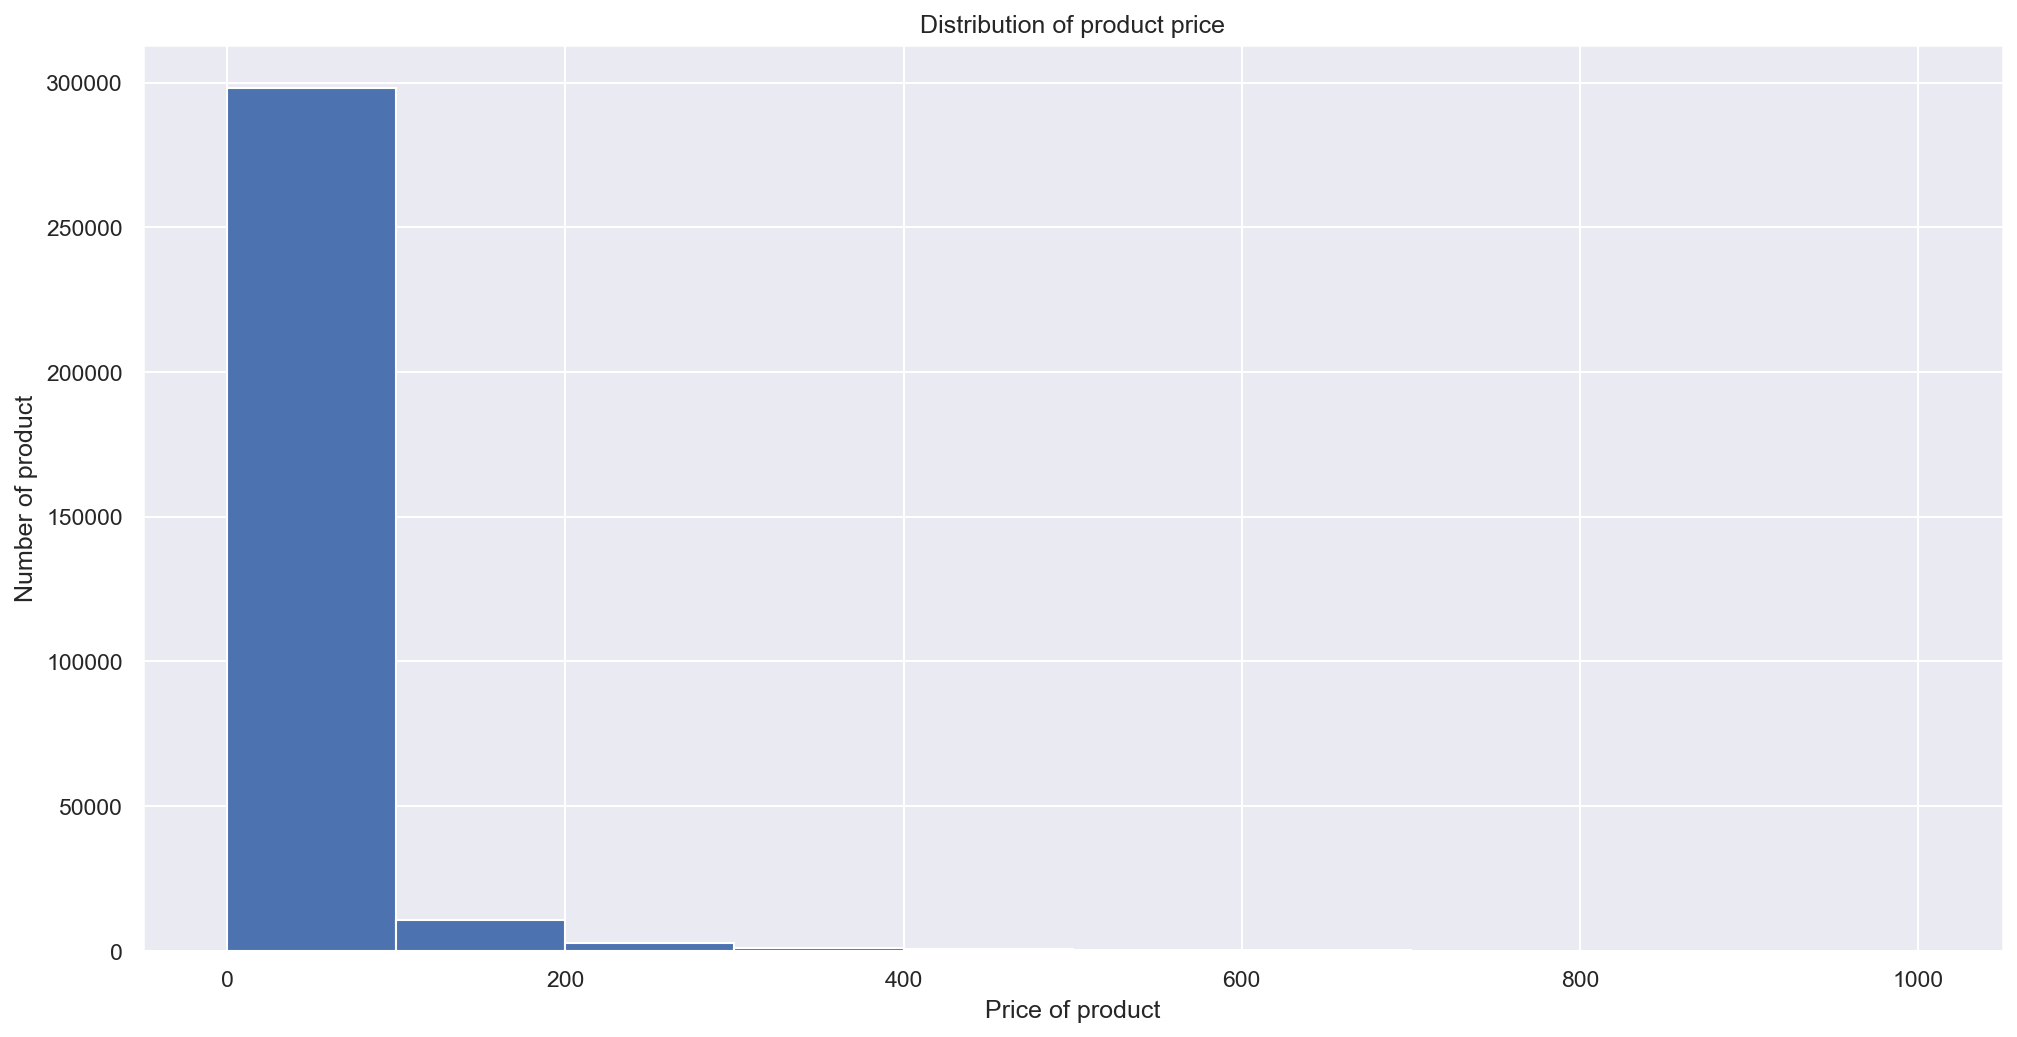

In [10]:
plt.hist(meta_data_1['intPrice'])
plt.title('Distribution of product price')
plt.xlabel('Price of product')
plt.ylabel('Number of product')

## Number of purchases for each product

### group by asin

In [11]:
number_of_purchases = meta_data_1.groupby('asin').size()
number_of_products = len(meta_data_1.groupby('asin').size())
number_of_purchases.describe()

count    310554.000000
mean          1.015588
std           0.123876
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
dtype: float64

Text(0, 0.5, 'Number of purchases')

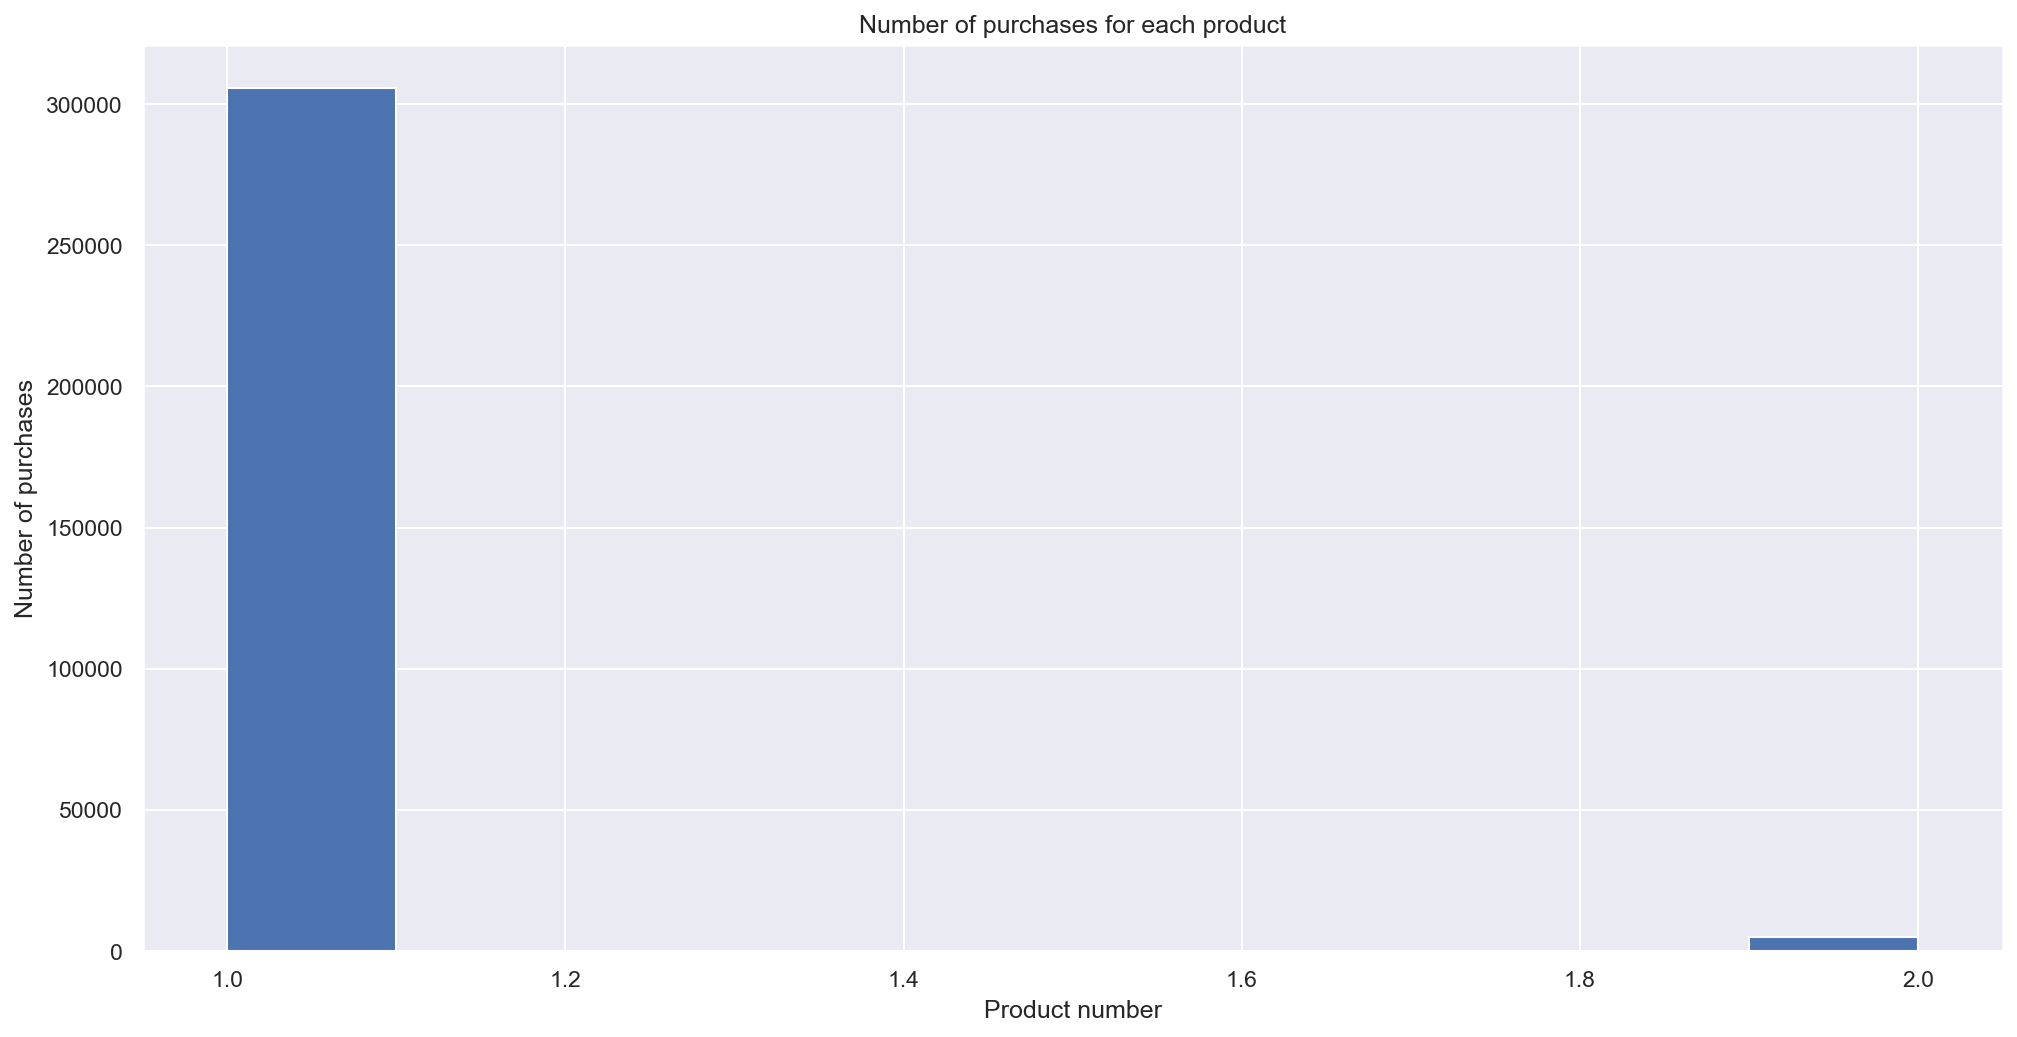

In [12]:
plt.hist(number_of_purchases)
plt.title('Number of purchases for each product')
plt.xlabel('Product number')
plt.ylabel('Number of purchases')

# Review data

In [13]:
review_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,image,style
0,2.0,12,False,"09 22, 2016",A1IDMI31WEANAF,0020232233,Mackenzie Kent,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...,1474502400,NaN,NaN
1,1.0,21,False,"09 18, 2016",A4BCEVVZ4Y3V3,0020232233,Jonathan Christian,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...,1474156800,NaN,NaN
2,3.0,19,True,"09 12, 2016",A2EZ9PY1IHHBX0,0020232233,unpreparedtodie,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless",1473638400,NaN,NaN
3,5.0,NaN,True,"03 2, 2017",A139PXTTC2LGHZ,0020232233,Ashley,Amazing buy! Bought it as a gift for our new d...,Five Stars,1488412800,NaN,NaN
4,1.0,3,True,"02 8, 2017",A3IB33V29XIL8O,0020232233,Oghma_EM,As my review of GF9's previous screens these w...,Money trap,1486512000,NaN,NaN


## Distribution for length of reviews 

In [14]:
review_data['review_length'] = review_data['reviewText'].str.count(" ")+1
review_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,image,style,review_length
0,2.0,12,False,"09 22, 2016",A1IDMI31WEANAF,0020232233,Mackenzie Kent,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...,1474502400,NaN,NaN,80.0
1,1.0,21,False,"09 18, 2016",A4BCEVVZ4Y3V3,0020232233,Jonathan Christian,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...,1474156800,NaN,NaN,125.0
2,3.0,19,True,"09 12, 2016",A2EZ9PY1IHHBX0,0020232233,unpreparedtodie,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless",1473638400,NaN,NaN,257.0
3,5.0,NaN,True,"03 2, 2017",A139PXTTC2LGHZ,0020232233,Ashley,Amazing buy! Bought it as a gift for our new d...,Five Stars,1488412800,NaN,NaN,14.0
4,1.0,3,True,"02 8, 2017",A3IB33V29XIL8O,0020232233,Oghma_EM,As my review of GF9's previous screens these w...,Money trap,1486512000,NaN,NaN,25.0


In [15]:
review_data['review_length'].describe()

count    8.194114e+06
mean     3.699494e+01
std      5.743502e+01
min      1.000000e+00
25%      8.000000e+00
50%      2.100000e+01
75%      4.300000e+01
max      5.745000e+03
Name: review_length, dtype: float64

Text(0, 0.5, 'Number of reviews')

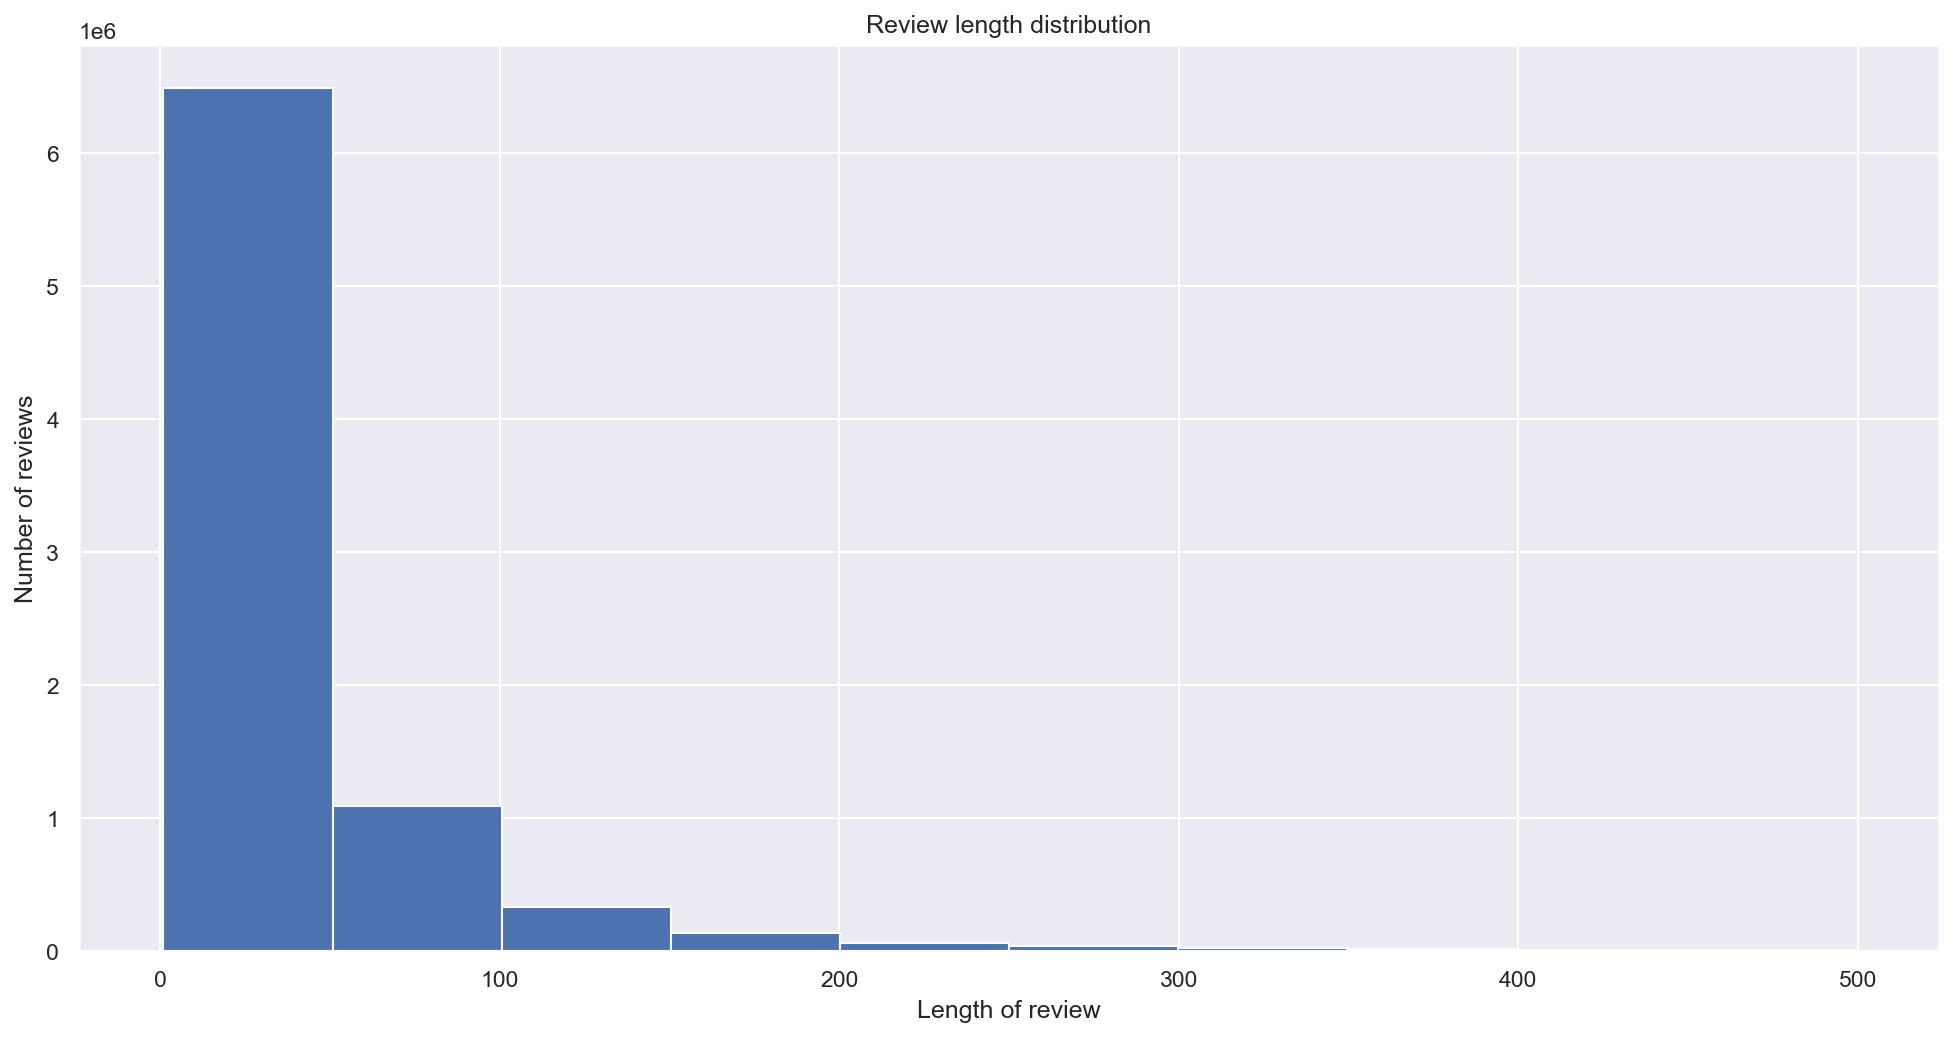

In [16]:
review_data_mask = review_data[review_data['review_length'] < 500]
plt.hist(review_data_mask['review_length'])
plt.title('Review length distribution')
plt.xlabel('Length of review')
plt.ylabel('Number of reviews')

## Number of rating for each product

In [17]:
NumberOfRating = review_data.groupby('asin').size()
NumberOfRating.describe()

count    624792.000000
mean         13.126338
std          66.866361
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max       12680.000000
dtype: float64

Text(0, 0.5, 'Number of rating')

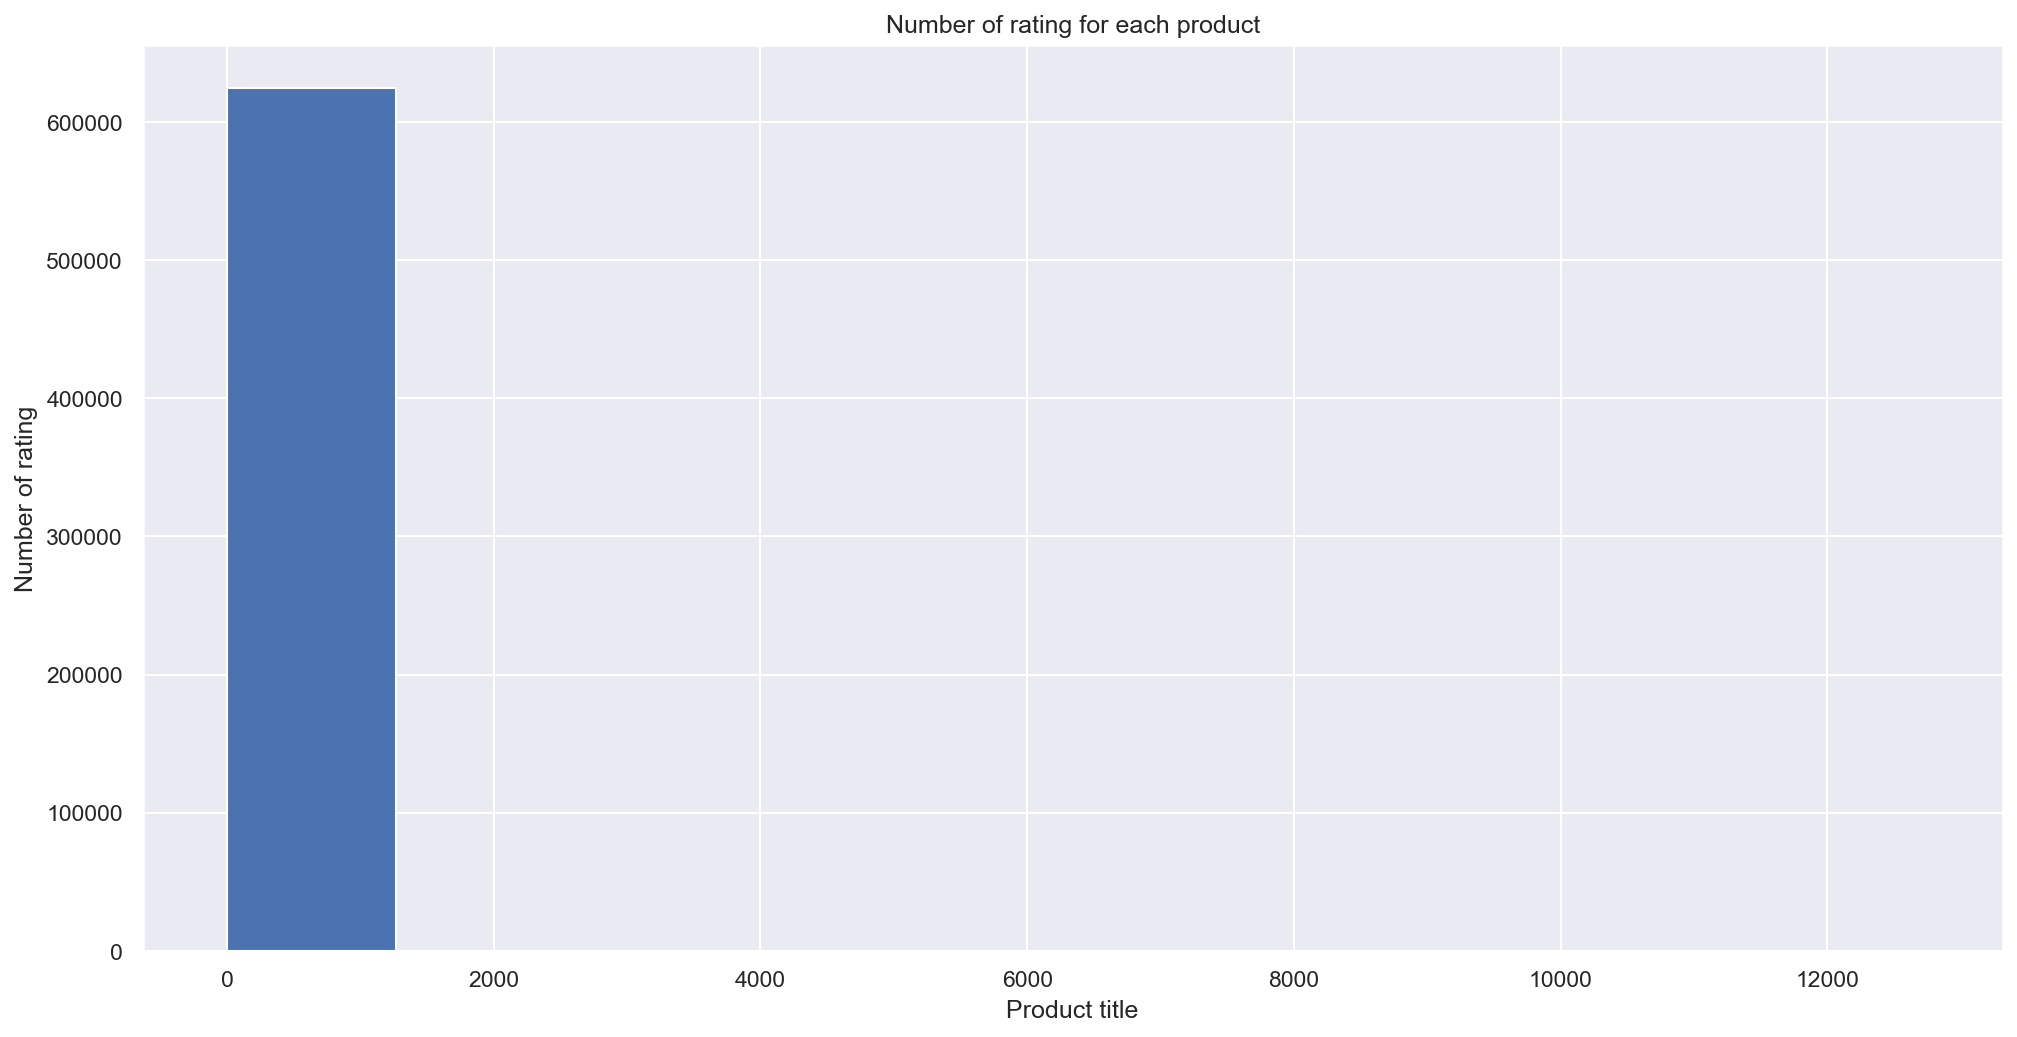

In [18]:
# Number of purchases for each product
plt.hist(NumberOfRating)
plt.title('Number of rating for each product')
plt.xlabel('Product title')
plt.ylabel('Number of rating')

#### Filter

Text(0, 0.5, 'Number of rating')

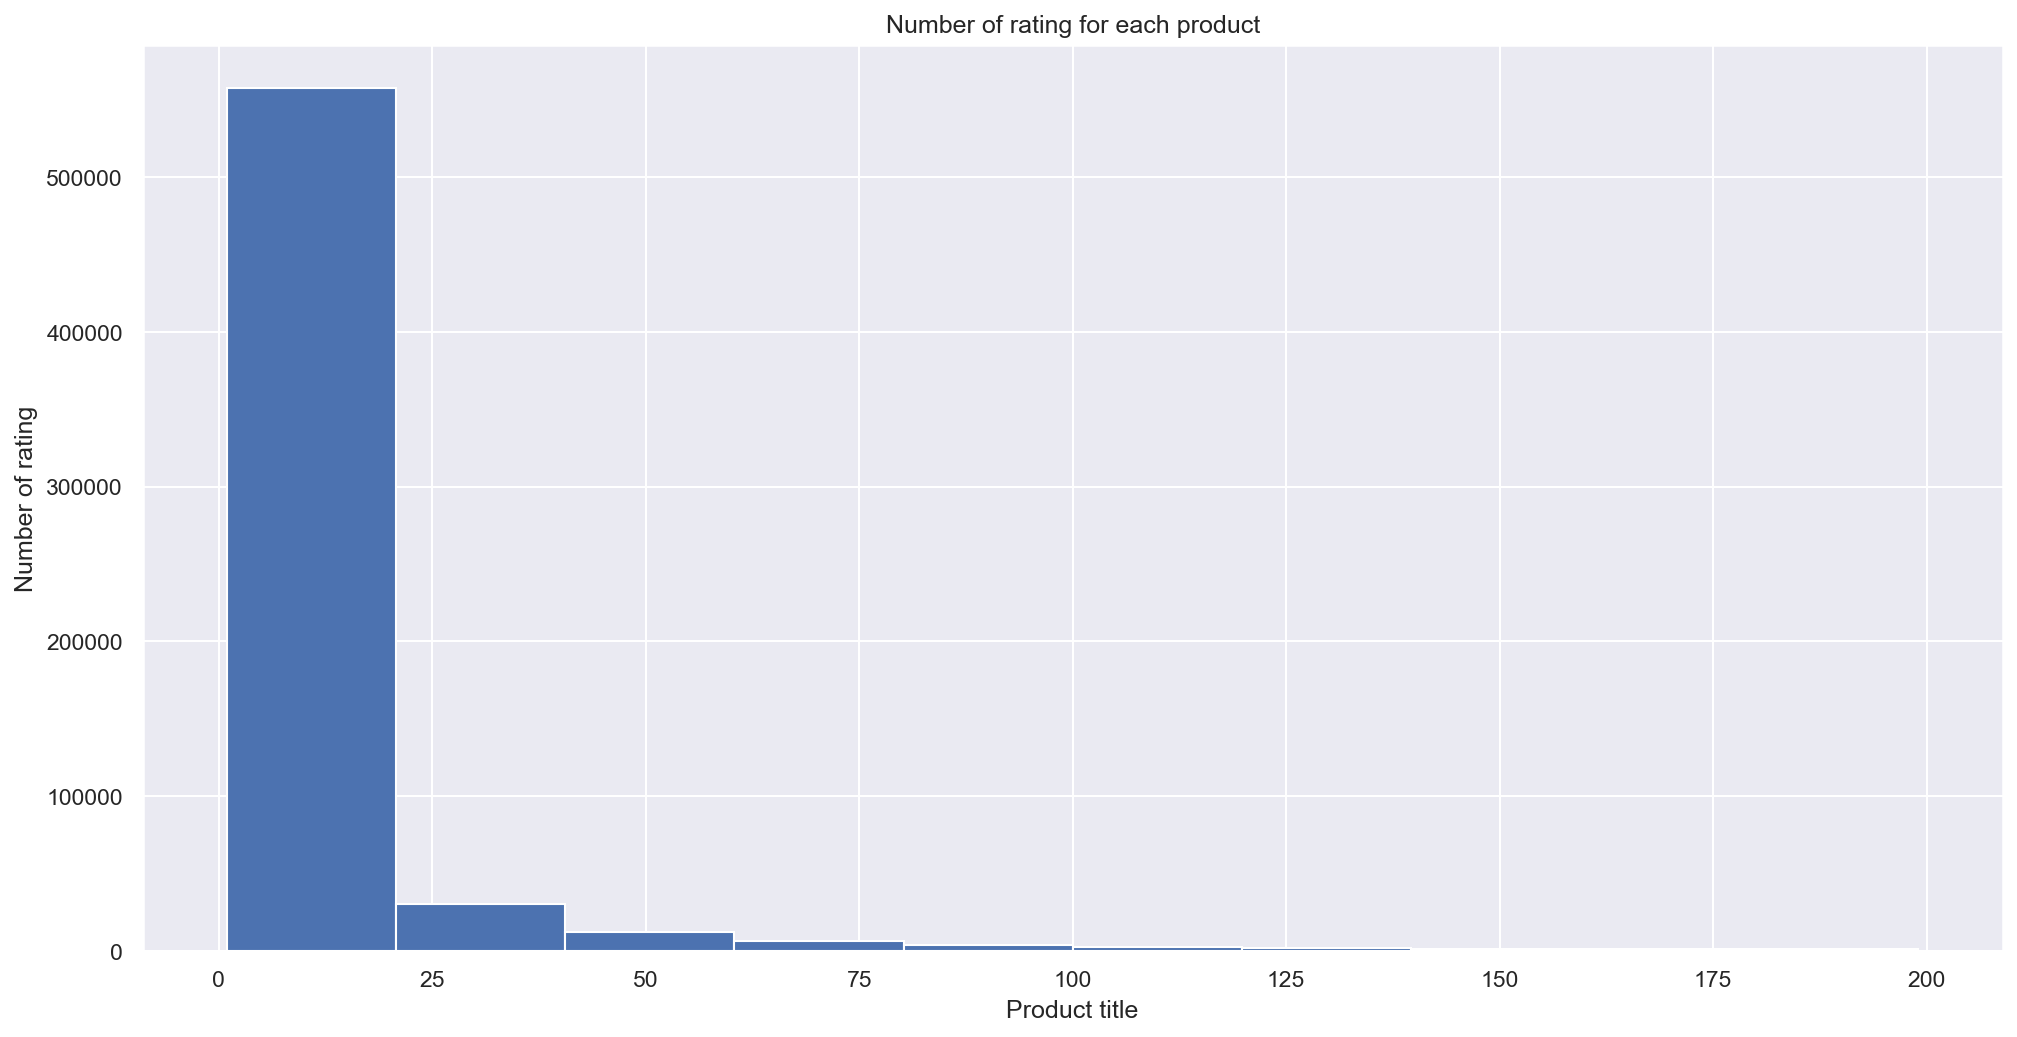

In [19]:
NumberOfRating1 = NumberOfRating[NumberOfRating < 200]
plt.hist(NumberOfRating1)
plt.title('Number of rating for each product')
plt.xlabel('Product title')
plt.ylabel('Number of rating')

#### Filter

Text(0, 0.5, 'Number of rating')

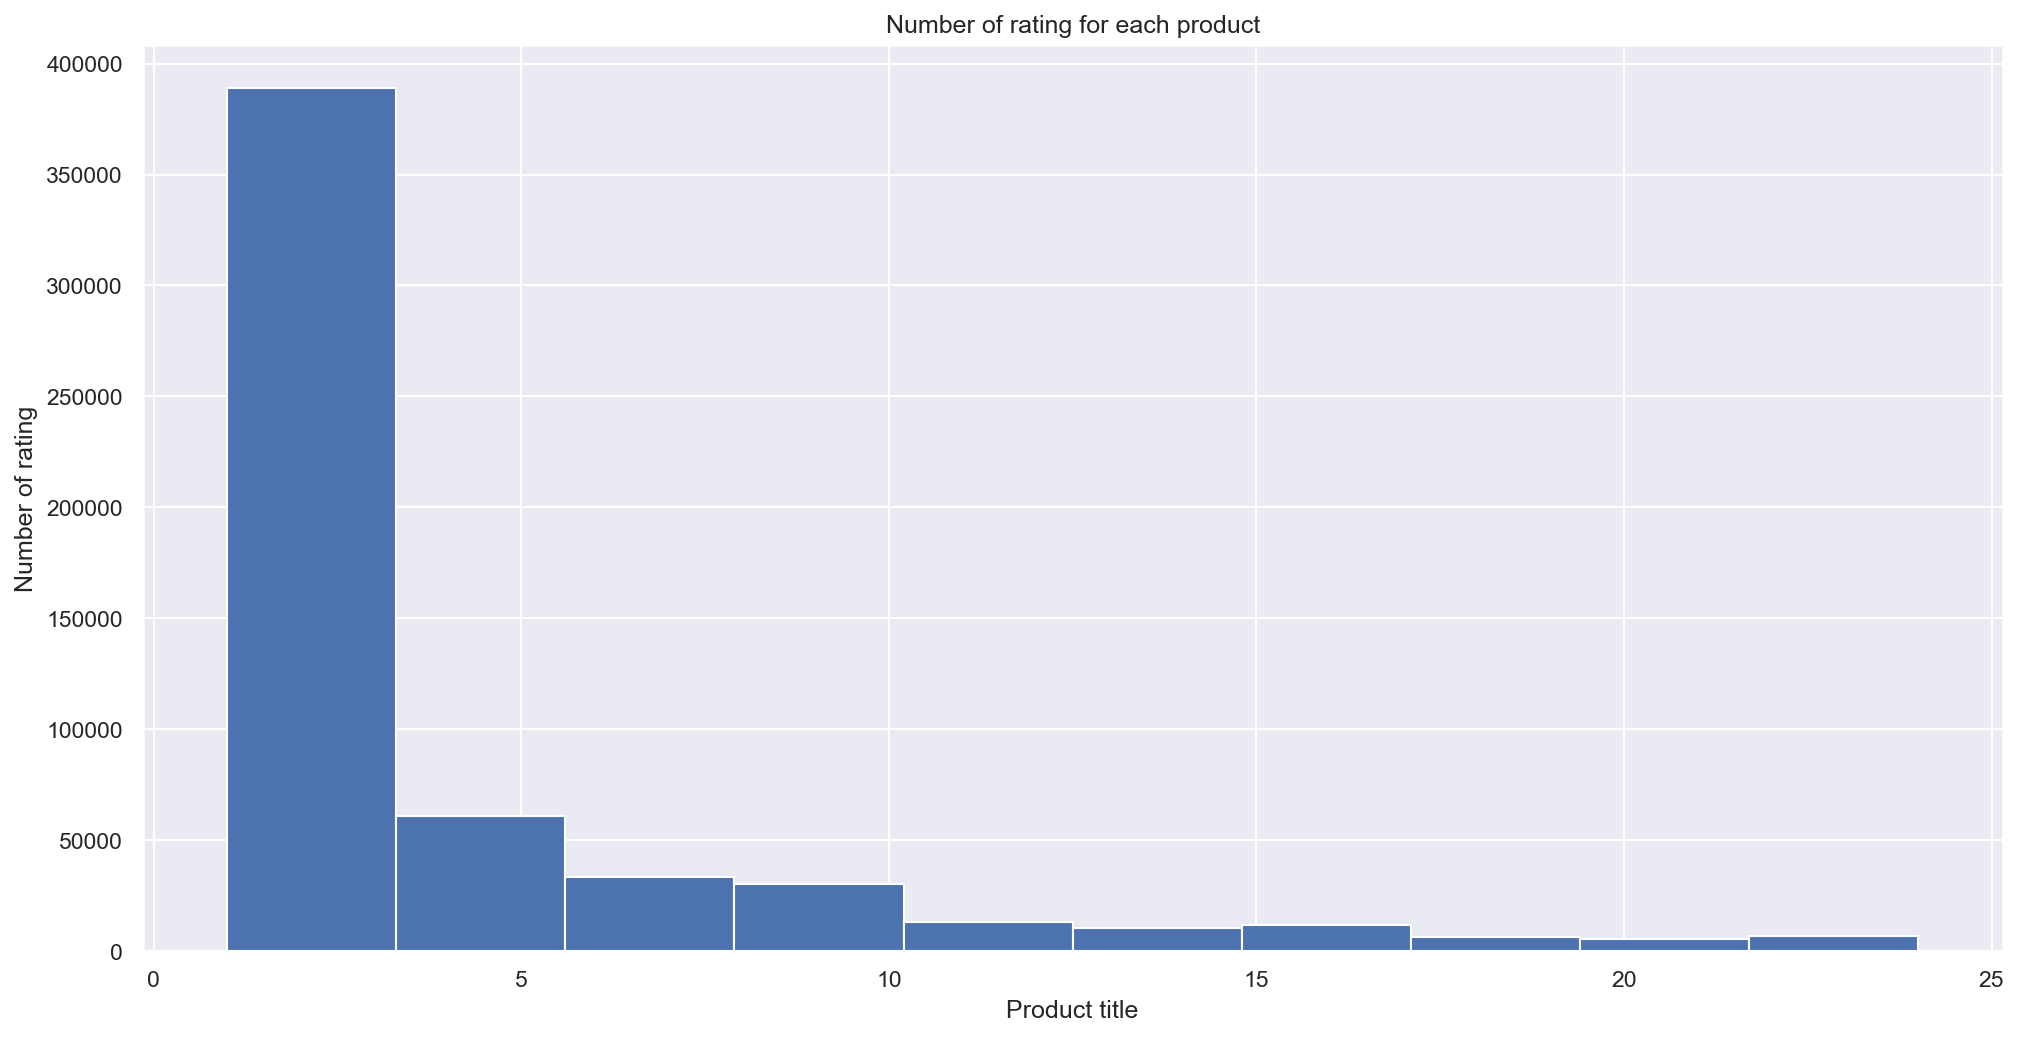

In [20]:
NumberOfRating2 = NumberOfRating[NumberOfRating < 25]
plt.hist(NumberOfRating2)
plt.title('Number of rating for each product')
plt.xlabel('Product title')
plt.ylabel('Number of rating')